<a href="https://colab.research.google.com/github/MohammadAli-Balaj/SRGAN_SHAHBAZ_AMNA/blob/main/SRGAN_MIRFLICKR_25000_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shahbaz Amna
## Artificial Neural Networks and Deep Learning II
### SRGANs for generating high quality images
#### Using Adam optimizer 20 epochs and each image as a batch (batch size = 1)

## GPU information:

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Importing libraries:

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from keras.models import load_model
from numpy.random import randint
from tqdm import tqdm
import random

## Accessing drive data:

In [ ]:
from google.colab import drive
drive.mount('data',force_remount=True)

Mounted at data


## Generator and discriminator blocks: 

In [ ]:
 
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model


def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model



def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


## VGG generated features and building combined model:

In [ ]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


## Training phase:

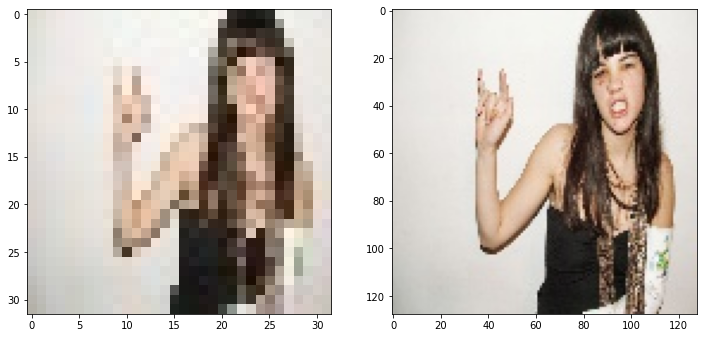

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_90 (Conv2D)             (None, 32, 32, 64)   15616       ['input_7[0][0]']                
                                                                                                  
 p_re_lu_38 (PReLU)             (None, 32, 32, 64)   64          ['conv2d_90[0][0]']              
                                                                                                  
 conv2d_91 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_38[0][0]']             
                                                                                            

  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step


  1%|▏         | 1/67 [00:06<07:29,  6.81s/it]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:06<03:08,  2.90s/it]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:07<01:45,  1.65s/it]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:07<01:06,  1.06s/it]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 5/67 [00:07<00:45,  1.37it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 6/67 [00:07<00:32,  1.89it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:07<00:24,  2.47it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:07<00:18,  3.12it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 9/67 [00:08<00:15,  3.78it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:08<00:13,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:08<00:11,  4.84it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:08<00:10,  5.33it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:08<00:09,  5.70it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:08<00:08,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 15/67 [00:08<00:08,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 16/67 [00:09<00:08,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:09<00:07,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 18/67 [00:09<00:07,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 19/67 [00:09<00:07,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 20/67 [00:09<00:07,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 21/67 [00:09<00:06,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 22/67 [00:09<00:06,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 23/67 [00:10<00:06,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 24/67 [00:10<00:06,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 25/67 [00:10<00:06,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 26/67 [00:10<00:06,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:10<00:05,  6.86it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 28/67 [00:10<00:05,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 29/67 [00:10<00:05,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 30/67 [00:11<00:05,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 31/67 [00:11<00:05,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 32/67 [00:11<00:05,  6.83it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 33/67 [00:11<00:04,  6.86it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 34/67 [00:11<00:04,  6.85it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:11<00:04,  6.82it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:11<00:04,  6.86it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 37/67 [00:12<00:04,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:12<00:04,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:12<00:04,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 40/67 [00:12<00:04,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 41/67 [00:12<00:03,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 42/67 [00:12<00:03,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 43/67 [00:13<00:03,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:13<00:03,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 45/67 [00:13<00:03,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:13<00:03,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 47/67 [00:13<00:02,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 48/67 [00:13<00:02,  6.81it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:13<00:02,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 50/67 [00:14<00:02,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 51/67 [00:14<00:02,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:14<00:02,  6.83it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 53/67 [00:14<00:02,  6.88it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:14<00:01,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 55/67 [00:14<00:01,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:14<00:01,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 57/67 [00:15<00:01,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 58/67 [00:15<00:01,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 59/67 [00:15<00:01,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:15<00:01,  6.82it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 61/67 [00:15<00:00,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:15<00:00,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:15<00:00,  6.80it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████▌| 64/67 [00:16<00:00,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 65/67 [00:16<00:00,  6.67it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 66/67 [00:16<00:00,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:16<00:00,  4.03it/s]


epoch: 1 g_loss: 174.00402017849595 d_loss: [13.43455215  0.51492537]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 1/67 [00:00<00:09,  6.95it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.86it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 7/67 [00:01<00:08,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.77it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.77it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.82it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:01<00:07,  6.86it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:07,  6.87it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.89it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 20/67 [00:02<00:06,  6.83it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.81it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:03<00:05,  6.75it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 33/67 [00:04<00:05,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 34/67 [00:04<00:04,  6.87it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:05<00:04,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.81it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.82it/s]

1/1 [==============================] - 0s 14ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 47/67 [00:06<00:03,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.58it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 53/67 [00:07<00:02,  6.75it/s]

1/1 [==============================] - 0s 14ms/step


 81%|████████  | 54/67 [00:07<00:01,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 60/67 [00:08<00:01,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 66/67 [00:09<00:00,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:09<00:00,  6.75it/s]


epoch: 2 g_loss: 135.89452518633942 d_loss: [3.82590373 0.67164179]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:09,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.83it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 5/67 [00:00<00:08,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 7/67 [00:01<00:08,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.84it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 13/67 [00:01<00:07,  6.75it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 14/67 [00:02<00:07,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 20/67 [00:02<00:06,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.78it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.75it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.82it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:03<00:05,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.69it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 33/67 [00:04<00:05,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 34/67 [00:05<00:04,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:05<00:04,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 47/67 [00:06<00:03,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 53/67 [00:07<00:02,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 60/67 [00:08<00:01,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:09<00:00,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 67/67 [00:09<00:00,  6.72it/s]


epoch: 3 g_loss: 123.89406890299783 d_loss: [1.43551728 0.7761194 ]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 6/67 [00:00<00:08,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:01<00:08,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.72it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:08,  6.40it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 20/67 [00:02<00:06,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.76it/s]

1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 27/67 [00:04<00:05,  6.72it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 33/67 [00:04<00:05,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 34/67 [00:05<00:04,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.82it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 41/67 [00:06<00:04,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 47/67 [00:07<00:02,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.83it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 53/67 [00:07<00:02,  6.83it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.85it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.82it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.81it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 60/67 [00:08<00:01,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.77it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.77it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.79it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 66/67 [00:09<00:00,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.69it/s]


epoch: 4 g_loss: 115.58100279053646 d_loss: [2.02153697 0.74626866]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.62it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 7/67 [00:01<00:08,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:07,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 20/67 [00:02<00:07,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 27/67 [00:04<00:06,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 33/67 [00:04<00:05,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 34/67 [00:05<00:04,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.50it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 40/67 [00:05<00:04,  6.74it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.72it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.75it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 47/67 [00:07<00:02,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.68it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 53/67 [00:07<00:02,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 54/67 [00:08<00:02,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:09<00:00,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.65it/s]


epoch: 5 g_loss: 109.76201544235002 d_loss: [0.94662368 0.79104478]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:09,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:10,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/67 [00:00<00:10,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 7/67 [00:01<00:09,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:07,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.75it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:07,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 27/67 [00:04<00:05,  6.77it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 33/67 [00:04<00:05,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 34/67 [00:05<00:04,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.75it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:07<00:04,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:07<00:03,  5.12it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 50/67 [00:07<00:03,  5.50it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 52/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 81%|████████  | 54/67 [00:08<00:02,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:09<00:01,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:10<00:00,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.48it/s]


epoch: 6 g_loss: 111.18939610381625 d_loss: [2.65419197 0.7238806 ]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 7/67 [00:01<00:08,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 14/67 [00:02<00:08,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 20/67 [00:02<00:07,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.77it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:04<00:06,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 33/67 [00:04<00:05,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 34/67 [00:05<00:04,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:05<00:04,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.61it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 53/67 [00:07<00:02,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.74it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 66/67 [00:09<00:00,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.66it/s]


epoch: 7 g_loss: 102.28353967239607 d_loss: [1.38092401 0.82089552]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 7/67 [00:01<00:09,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:07,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:04<00:06,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 33/67 [00:04<00:05,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 34/67 [00:05<00:04,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.58it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.53it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.59it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.46it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.55it/s]


epoch: 8 g_loss: 97.26632149539776 d_loss: [1.16024818 0.80597015]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.76it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 6/67 [00:00<00:08,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:01<00:08,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:07,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.73it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 27/67 [00:04<00:05,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 33/67 [00:04<00:05,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 41/67 [00:06<00:04,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 48/67 [00:07<00:03,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 54/67 [00:08<00:02,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.59it/s]


epoch: 9 g_loss: 92.84224118759383 d_loss: [1.07937122 0.88059701]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:09,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:01<00:09,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:08,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 27/67 [00:04<00:06,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 33/67 [00:04<00:05,  6.57it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.59it/s]


epoch: 10 g_loss: 89.58687510419247 d_loss: [0.65192351 0.90298507]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/67 [00:00<00:09,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 7/67 [00:01<00:09,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 13/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:08,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 15/67 [00:02<00:08,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.71it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.69it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:04<00:05,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 33/67 [00:05<00:05,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.70it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.63it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 54/67 [00:08<00:02,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.57it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:10<00:00,  6.56it/s]


epoch: 11 g_loss: 87.98191416441504 d_loss: [0.29704115 0.92537313]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 1/67 [00:00<00:09,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 7/67 [00:01<00:09,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:01<00:09,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 9/67 [00:01<00:09,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:08,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 15/67 [00:02<00:08,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 27/67 [00:04<00:06,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.68it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.72it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 33/67 [00:05<00:05,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 34/67 [00:05<00:04,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:10<00:00,  6.58it/s]


epoch: 12 g_loss: 88.14626174186593 d_loss: [1.37538883 0.8880597 ]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 7/67 [00:01<00:09,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:09,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 9/67 [00:01<00:09,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 13/67 [00:02<00:08,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 14/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 15/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 16/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 18/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 19/67 [00:03<00:08,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 20/67 [00:03<00:08,  5.51it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:08,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 22/67 [00:03<00:07,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 23/67 [00:03<00:07,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 24/67 [00:03<00:07,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 25/67 [00:04<00:07,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 26/67 [00:04<00:07,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 27/67 [00:04<00:07,  5.27it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:07,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 29/67 [00:04<00:07,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 30/67 [00:05<00:06,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:05<00:06,  5.60it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:05<00:06,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 33/67 [00:05<00:05,  5.77it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 34/67 [00:05<00:05,  5.67it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 35/67 [00:05<00:05,  5.84it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:06<00:05,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 37/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:06<00:04,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:06<00:04,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:07<00:03,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:07<00:03,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 45/67 [00:07<00:03,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:07<00:03,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:08<00:02,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 50/67 [00:08<00:02,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:08<00:02,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 52/67 [00:08<00:02,  6.72it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 56/67 [00:09<00:01,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:09<00:01,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 58/67 [00:09<00:01,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 59/67 [00:09<00:01,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.61it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:10<00:00,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:10<00:00,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 64/67 [00:10<00:00,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 65/67 [00:10<00:00,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.20it/s]


epoch: 13 g_loss: 88.24085400709465 d_loss: [1.04749635 0.87313433]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:01<00:09,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:09,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 13/67 [00:02<00:08,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:08,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 15/67 [00:02<00:08,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:07,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.53it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 27/67 [00:04<00:06,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 33/67 [00:05<00:05,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 35/67 [00:05<00:05,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 39/67 [00:06<00:04,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 41/67 [00:06<00:04,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 46/67 [00:07<00:03,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:08<00:02,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:08<00:02,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:09<00:01,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:10<00:00,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:10<00:00,  6.49it/s]


epoch: 14 g_loss: 85.26179910061964 d_loss: [1.27290673 0.8880597 ]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.61it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:01<00:09,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:09,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:08,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 16/67 [00:02<00:08,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:07,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.58it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:04<00:06,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 33/67 [00:05<00:05,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 41/67 [00:06<00:04,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 46/67 [00:07<00:03,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 59/67 [00:09<00:01,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:10<00:00,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:10<00:00,  6.48it/s]


epoch: 15 g_loss: 85.39274195770719 d_loss: [0.99454853 0.93283582]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:01<00:09,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 8/67 [00:01<00:09,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 13/67 [00:02<00:08,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 14/67 [00:02<00:08,  6.53it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.56it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 21/67 [00:03<00:07,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 22/67 [00:03<00:07,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 26/67 [00:04<00:06,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:04<00:06,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 28/67 [00:04<00:06,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 33/67 [00:05<00:05,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:06<00:04,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 46/67 [00:07<00:03,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:08<00:02,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 59/67 [00:09<00:01,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.50it/s]


epoch: 16 g_loss: 83.38448308119133 d_loss: [0.47275138 0.96268657]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 7/67 [00:01<00:09,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:09,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:08,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 15/67 [00:02<00:08,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.51it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:04<00:06,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 33/67 [00:05<00:05,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 39/67 [00:06<00:04,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 41/67 [00:06<00:04,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:07<00:03,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 59/67 [00:09<00:01,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:10<00:00,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:10<00:00,  6.49it/s]


epoch: 17 g_loss: 81.72669040622996 d_loss: [0.90729282 0.8880597 ]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:00<00:09,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.66it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:01<00:09,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.59it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 14/67 [00:02<00:07,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.56it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:03<00:06,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.66it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.64it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 27/67 [00:04<00:06,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 33/67 [00:05<00:05,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 41/67 [00:06<00:03,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:06<00:03,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.59it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.60it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:08<00:02,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 59/67 [00:08<00:01,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.60it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.58it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:10<00:00,  6.57it/s]


epoch: 18 g_loss: 80.13802813060248 d_loss: [0.52085754 0.91791045]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/67 [00:00<00:09,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/67 [00:00<00:10,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.49it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.51it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 7/67 [00:01<00:09,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:02<00:08,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:08,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 21/67 [00:03<00:07,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 26/67 [00:04<00:06,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 27/67 [00:04<00:06,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 33/67 [00:05<00:05,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 41/67 [00:06<00:04,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.59it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 46/67 [00:07<00:03,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:09<00:01,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.59it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:10<00:00,  6.51it/s]


epoch: 19 g_loss: 82.17652366410441 d_loss: [0.93444354 0.91044776]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/67 [00:00<00:10,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:00<00:09,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:00<00:09,  6.59it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 5/67 [00:00<00:09,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:00<00:09,  6.67it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:01<00:09,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:01<00:08,  6.65it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 9/67 [00:01<00:08,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:01<00:08,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 11/67 [00:01<00:08,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 12/67 [00:01<00:08,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 13/67 [00:01<00:08,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:02<00:08,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 15/67 [00:02<00:07,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 16/67 [00:02<00:07,  6.66it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 17/67 [00:02<00:07,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 18/67 [00:02<00:07,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 19/67 [00:02<00:07,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 20/67 [00:03<00:07,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 21/67 [00:03<00:07,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 22/67 [00:03<00:06,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 23/67 [00:03<00:06,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 24/67 [00:03<00:06,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 25/67 [00:03<00:06,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:03<00:06,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 27/67 [00:04<00:06,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:04<00:05,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 29/67 [00:04<00:05,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 30/67 [00:04<00:05,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 31/67 [00:04<00:05,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 32/67 [00:04<00:05,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 33/67 [00:05<00:05,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 34/67 [00:05<00:05,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 35/67 [00:05<00:04,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 36/67 [00:05<00:04,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 37/67 [00:05<00:04,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 38/67 [00:05<00:04,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 39/67 [00:05<00:04,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 40/67 [00:06<00:04,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 41/67 [00:06<00:04,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 42/67 [00:06<00:03,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 43/67 [00:06<00:03,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:06<00:03,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 45/67 [00:06<00:03,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 46/67 [00:07<00:03,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 47/67 [00:07<00:03,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 48/67 [00:07<00:02,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 49/67 [00:07<00:02,  6.59it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 50/67 [00:07<00:02,  6.63it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 51/67 [00:07<00:02,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:07<00:02,  6.68it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 53/67 [00:08<00:02,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 54/67 [00:08<00:01,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 55/67 [00:08<00:01,  6.68it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:08<00:01,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:08<00:01,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 58/67 [00:08<00:01,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:09<00:01,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 60/67 [00:09<00:01,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 61/67 [00:09<00:00,  6.58it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:09<00:00,  6.62it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:09<00:00,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 64/67 [00:09<00:00,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:09<00:00,  6.69it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 66/67 [00:10<00:00,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:10<00:00,  6.53it/s]


epoch: 20 g_loss: 79.3741014964545 d_loss: [0.8635856  0.87313433]


In [ ]:
n=100

lr_list = os.listdir("/content/data/MyDrive/data/lr")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/data/MyDrive/data/lr/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("/content/data/MyDrive/data/hr")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/data/MyDrive/data/hr/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

lr_images = lr_images / 255.
hr_images = hr_images / 255.

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()


batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 20
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) 
    real_label = np.ones((batch_size,1)) 
    

    g_losses = []
    d_losses = []
    

    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b] 
        
        fake_imgs = generator.predict_on_batch(lr_imgs)
        

        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        

        discriminator.trainable = False
        

        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 

        image_features = vgg.predict(hr_imgs)
     

        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        

        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
 
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    

    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0:
        
        generator.save("gen_e_"+ str(e+1) +".h5")

## Using saved model to generate high resolution images:

### Version with 10 epochs:

1/1 [==============================] - 1s 644ms/step


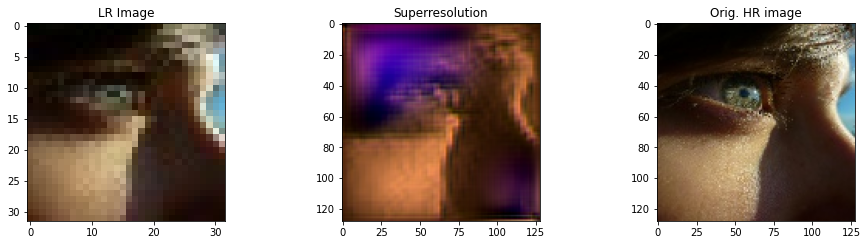

In [ ]:
generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()